In [2]:
import numpy as np
import pyvisa
import time
from datetime import date
import matplotlib.pyplot as plt
import csv
import os
from decimal import Decimal, getcontext

In [ ]:
class RP7972A():
    """Esta clase pide y mide los datos de la fuente, para luego ser procesados"""
    def __init__(self, curr_initialFreq, curr_finalFreq, points_per_decade, curr_amplitude, rp_USB=None):
        """Define variables de entrada como variables globales en la clase"""
        self.curr_initialFreq = curr_initialFreq
        self.curr_finalFreq = curr_finalFreq
        self.curr_amplitude = curr_amplitude
        self.curr_Freqs = [] #an array of the frequencies used for the sweep
        self.points_per_decade = points_per_decade # the points per decade to generate the frequencies for the sweep

        self.rp_USB=rp_USB
        # FOR INITIALIZATION OF POWER SOURCE (RP7972A)
        rm = pyvisa.ResourceManager()
        devices = rm.list_resources()

        print("Searching for devices...")
        if devices:
            for device in devices:
                try:
                    my_instrument = rm.open_resource(str(device))
                    device_ID=my_instrument.query('*IDN?')
                    if  "RP797" in device_ID:#if the RP7972 is found assign it to rp_USB
                        self.rp_USB=my_instrument
                        print("Found and connected to: "+device_ID)
                        break
                    else:#close other devices
                        my_instrument.close()
                except:
                    print("Error: No response from found device")
            if not self.rp_USB:
                print("No RP7972 power supply was found.")
                rm.close()
        else:
            print("No devices were found")

    #=============== ARB functions ===================
    def config_arb(self, frequency):
        """Para generar las señales de corriente que se envian a la fuente, se tiene que llamar por cada frecuencia, no es sweep"""
        """INFO: service manual, cap 4, Programming an Arbitrary Waveform"""
        self.arb_cycles, arb_points_per_cycle = self.cycles_per_frequency(frequency);
        arb_points, dwell_time = self.arb_data(frequency, arb_points_per_cycle);
        ms = {}
        # Set output priority mode to current
        ms['priority_mode'] = "FUNC CURR, (@1)"
        # Set voltage limit (necessary for output priority mode)
        ms['voltage_limit'] = "VOLT:LIM " + str(self.voltage_limit) + ", (@1)"
        # Cancel any transients or arbs
        ms['abort_transient_1'] = "ABOR:TRAN, (@1)"
        # Set arbitrary function type to current
        ms['arb_func_type'] = "ARB:FUNC:TYPE CURR,(@1)"
        # Set arbitrary function shape to CDW
        ms['arb_func_shape'] = "ARB:FUNC:SHAP CDW,(@1)"
        # Set the arb to repeat an infinite amount of times
        #arb_cycles = INF
        ms['arb_count'] = "ARB:COUN " + str(self.arb_cycles) + ", (@1)"
        # Set the last current setting when the arb ends to 1A
        ms['arb_term_last'] = "ARB:TERM:LAST 0,(@1)"
        # Set the mode of the current to be an Arbitrary signal
        ms['curr_mode'] = "CURR:MODE ARB,(@1)"
        # Set the source of the arbitrary trigger to Bus
        ms['trig_arb_source'] = "TRIG:ARB:SOUR B"
        # Set the dwell time for the signal (associated with the frequency)
        ms['arb_curr_cdw_dwell'] = "ARB:CURR:CDW:DWELL " + str(dwell_time) + ", (@1)"
        # Set slew rate setting (for testing)
        ms['curr_slew'] = "CURR:SLEW INF"
        # Prepares to send out the current points
        ms['current_points'] = (arb_points*self.curr_amplitude)#-self.curr_amplitude
        # Initiates the output
        ms["output_init"] = "OUTP 1,(@1)"
        # Initiates the transient  
        ms["init_tran"] = "INIT:TRAN (@1)"
        # Triggers the transient   ### Commented out to trigger it independently
        #ms["trig_tran"] = "TRIG:TRAN (@1)"

        for message in ms:
            if message != "current_points":
                self.scpi_out(ms[message])
            else:
                self.scpi_points_out(ms[message])

        self.signal_time = self.arb_cycles/frequency  
        self.time_interval = 1/(frequency*400)#TODO: Define this for measure_setup method
        
    def trigger_arb(self):
        try:
            self.scpi_out("TRIG:TRAN ,(@1)")
        except:
            print("Error: Could not send the trigger command")

    # TOOLBOX
    def sweep_frequencies(self):
        """A partir de las frecuencias inicial y final y la cantidad de sweep points se definen las frecuencias sobre las que se hará el barrido"""
        decade=0 #An exponent that iterates in the while
        upper_lim=False
        log_points=(np.logspace(0,1,self.points_per_decade,False))#generates an array of points equally distributed on a log scale from 1 to 10 based on the ppd given
        while not upper_lim:#loops as long as the frequency values calculated don't exceed the final frequency
            frec_array=(self.curr_initialFreq*10**decade)*log_points#applies the log distributed point array to the initial frequency
            for i in frec_array:#goes through every point in the array generated in the previous line
                if i < self.curr_finalFreq:#if the value is less than the final frequency it gets appended to the 
                    self.curr_Freqs.append(float(i))
                else:
                    upper_lim = True #breaks the while
            decade +=1 #ups the exponent for the next decade
        self.curr_Freqs.append(self.curr_finalFreq) #adds the final frequency


    def cycles_per_frequency(self, freq):
        """Switch para definir ciclos por frecuencia, recibe una frequencia saca cantidad de ciclos"""
        if 1000 <= freq <= 2000:
            cycles = 40
            points_per_cycle = 50
        elif 100 <= freq < 1000:
            cycles = 40
            points_per_cycle = 100
        elif 10 <= freq < 100:
            cycles = 20
            points_per_cycle = 100
        elif 1 <= freq < 10:
            cycles = 10
            points_per_cycle = 100
        elif 100/1000 <= freq < 1:
            cycles = 5
            points_per_cycle = 100
        elif 10/1000 <= freq < 100/1000:
            cycles = 2
            points_per_cycle = 1000
        elif 1/1000 <= freq < 10/1000:
            cycles = 1
            points_per_cycle = 1000
        elif freq<2000:#added this in case user inputs higher than 2000 frequencies 
            cycles = 40
            points_per_cycle = 50
        return cycles, points_per_cycle
    def arb_data(self, frequency, points_per_cycle):
        """Generates data points for arb generation and dwell time for a frequency that is input.
        Minimum dwell time is 10 us (10*10^-6s)"""
        x = np.linspace(0, 2*np.pi, points_per_cycle)
        sin_points=np.sin(x)
        dwell_time=(1/frequency)/points_per_cycle
        return sin_points, dwell_time
        # Serán 1000 puntos por ciclo máximo, si hay problemas lo reduciremos (dato random)\

    #=============== SCPI communication functions ===================
    def scpi_out(self, command):
        """Outputs an encoded scpi string on serial port"""
        try:
            self.rp_USB.write(str(command),"\n")
        except:
            print("ERROR: Could not send the message: " + str(command))
    def scpi_points_out(self, values):
        """Outputs the command to set the ARB points and the points as scpi values"""
        try:
            self.rp_USB.write_ascii_values('ARB:CURR:CDW ', values, "f",",","\n")
        except:
            print("ERROR: Could not send array of ascii points")
    def scpi_query(self, query):
        try:
            response=self.rp_USB.query(str(query))
            return response
        except:
            print("ERROR: Could not send query: " + str(query))
            return ""
    def status_check(self):
        """Returns a string containing a binary with status according to the following 
        7:CV, 6:CC, 5:OFF, 4:WTG-meas, 3:WTG-tran, 2:MEAS-active, 1:TRAN-active, 0:CP"""
        status=0
        try:
            status = self.scpi_query("STAT:OPER:COND?")
            return format(int(status[1:]),"08b")
        except:
            print("Error: Could not perform status check")
            return format(status,"08b")
    def stop(self):
        try:
            self.rp_USB.write("ABOR:TRANsient","\n")
            self.rp_USB.write("OUTP OFF","\n")
            #self.rp_USB.write("ABOR:ACQ","\n")
        except:
            print("ERROR: Could not send stop commands")
    
    #=============== MEASURE functions ===================
    def measure_setup(self,offset_points=10,dead_points=10):
        """Query the device for voltage points using the MEASure:ARRay:VOLTage[:DC]? command"""
        try:
            self.offset_points=offset_points
            self.dead_points=dead_points
            point_num=str(int(np.ceil((self.signal_time/self.time_interval)+dead_points+offset_points)))
            self.scpi_out("SENS:FUNC:CURR 1")
            self.scpi_out("SENS:FUNC:VOLT 1")
            self.scpi_out("SENS:SWE:OFFS:POIN "+str(offset_points))
            self.scpi_out("SENS:SWE:TINT "+ str(self.time_interval))
            print("Time interval: "+ str(self.time_interval))
            self.scpi_out("SENS:SWE:POIN "+str(200*point_num))
            print("Point number "+str(point_num))
            self.scpi_out("TRIG:ACQ:SOUR B")
            self.scpi_out("INIT:ACQ")
        except:
            print("ERROR: could not configure measure")
    def fetch(self):
        try:
            status = self.status_check()
            status_meas = int(status[2])

            while int(status_meas):
                time.sleep(1)
                status = self.status_check()
                status_meas = int(status[2])

            print("fetching voltage")
            voltage =self.rp_USB.query_ascii_values("FETC:ARR:VOLT?","f",",")
            print("fetching current")
            current = self.rp_USB.query_ascii_values("FETC:ARR:CURR?","f",",")
            print("Fetch successful")
            return voltage, current
        except:
            print("Error: no measure data received")
            return [0], [0]

class csvExporter():
    def __init__(self, filename:str,):
        self.filename = filename
    def openFile(self):
        ######## if no name was given
        filename=self.filename
        if filename == "":
            filename = "output-"+str(date.today())
                ####### check if file exists to create or create one with a number next to it
        has_same_name= True
        file_num=2
        name_length=len(filename)
        while has_same_name:
            if not os.path.exists(filename+".csv"):
                with open(filename+".csv", "w") as file:
                    has_same_name = False
            else:
                filename=filename[:name_length]+"-"+str(file_num)
                file_num+=1
        self.filename=filename
        
    def saveData(initial_frequency,final_frequency,points_per_decade,current_amplitude,voltage:list, current:list, f:float, cycles, time_interval, signal_time, offset_points, dead_points):
        #TODO: Change parameters to arrays instead of individual things
        filename=self.filename
        with open(filename+".csv", "r") as file:
            content = file.read()
        #### writes the data to the file 
        print("Saving data to: "+ self.filename+".csv")
        if not content:
            with open(filename +".csv", "a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow(["Amplitude " ,     "Initial Frequency",    "Final Frequency",  "Points per Decade"])
                writer.writerow([current_amplitude, initial_frequency,      final_frequency,    points_per_decade])
                writer.writerow(["Current Frequency", "Cycles", "Time Interval (Sampling)",  "Signal Time", "Offset Points", "Dead Points"])
                writer.writerow(["Voltage"])
                writer.writerow(["Current"])
        with open(filename+".csv", "a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([f, cycles, time_interval, signal_time, offset_points, dead_points])
            writer.writerow(voltage)
            writer.writerow(current)
    def saveImpedanceData(self,complex_impedances_a, complex_impedances_p):
        with open(self.filename+".csv", "a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Complex Impedances Amplitudes (Ohms)"])
            writer.writerow(complex_impedances_a)
            writer.writerow(["Complex Impedances Phases (Degrees)"])
            writer.writerow(complex_impedances_p)


class EIS():
    """This function processes the data from a CSV and applies the Electrochemical Impedance Spectroscopy Algorithm"""
    def __init__(self, file_name:str):
        self.file_name = file_name+".csv"
    def unpack(self):
        with open(self.file_name, "r") as file:
            reader = csv.reader(file)
            rows = list(reader)  # Convert to list for idx access
        """["Amplitude " ,     "Initial Frequency",    "Final Frequency",  "Points per Decade"]"""
        self.general_data = rows[1]
        rows = rows[5:]
        for row in range(len(rows)):
            for item in range(len(rows[row])):
                rows[row][item] = float(rows[row][item])
        self.frequency_data = {} #Of type dict, key is the frequency, item is a list with parameters and two lists with voltage values and current values
        for iteration in range(int(len(rows)/3)):
            self.frequency_data[float(rows[iteration*3][0])] = [rows[iteration*3][1:],rows[iteration*3+1],rows[iteration*3+2]]
        """""Frequency":[[Cycles", "Time Interval (Sampling)",  "Signal Time", "Offset Points", "Dead Points"], "Voltage", "Current"]"""
    def zero_crossing_algorithm(self, signal:list, offset = "unknown"):
        """Returns the indexes at which the signal crosses the offset of the signal"""
        if offset == "unknown":
            offset = (np.max(signal)+np.min(signal))/2
        #Creates two arrays to hold the indexes of points over or under the offset
        signal_over_offset = []
        signal_under_offset = []
        c = 0
        for point in signal:
            if point >= offset:
                signal_over_offset.append(c)
            elif point < offset:
                signal_under_offset.append(c)
            c+=1
        #References for modifying the lists
        signal_over_offset_ref = signal_over_offset
        signal_under_offset_ref = signal_under_offset
        def filter_list(list1, list2):
            """filter_list(list1, list2) returns a new list containing only the elements from list1 that have 
            at least one neighbor of x (x-2, x-1, x+1, or x+2) present in list2."""
            return [x for x in list1 if any(neighbor in list2 for neighbor in [x - 2, x - 1, x + 1, x + 2])]
        #Filters lists to leave only zero crossing relevant points
        signal_over_offset = filter_list(signal_over_offset, signal_under_offset_ref)
        signal_under_offset = filter_list(signal_under_offset, signal_over_offset_ref)
        signal_zero_blocks = sorted(signal_over_offset+signal_under_offset)
        def split_by_gap(input_list):
            """split_by_gap(input_list) takes a list of numbers and returns a list of sublists, 
            grouping together consecutive elements where the difference between neighboring items is 5 or less. 
            A new sublist is started whenever the gap between two numbers exceeds 5."""
            result = [[input_list[0]]]
            for current in input_list[1:]:
                if abs(current - result[-1][-1]) > 30:
                    result.append([current])
                else:
                    result[-1].append(current)
            return result
        signal_zero_crossing_blocks = split_by_gap(signal_zero_blocks)
        signal_zero_crossing = []
        for block in signal_zero_crossing_blocks:
            signal_zero_crossing.append(int(np.ceil((block[0]+block[-1])/2)))
        return signal_zero_crossing
    def get_phase_shift(self, frequency, v_zero_crossing:list, i_zero_crossing:list):
        """Returns shift in degrees"""
        getcontext().prec = 10
        time_interval = self.frequency_data[frequency][0][1]
        time_differences=[]
        max_idx_diff=v_zero_crossing[1]-v_zero_crossing[0]
        if (i_zero_crossing[0]-v_zero_crossing[0]) > max_idx_diff/2:
            v_zero_crossing.pop(0)
        elif (v_zero_crossing[0]-i_zero_crossing[0]) > max_idx_diff/2:
            i_zero_crossing.pop(0)
        for i in range(min(len(v_zero_crossing), len(i_zero_crossing))):
            time_differences.append(Decimal(str(i_zero_crossing[i]*time_interval))-Decimal(str(v_zero_crossing[i]*time_interval)))
        time_differences_mean=Decimal(np.mean(time_differences))
        # print("time_differences_mean: "+str(time_differences_mean))
        # print("freq: "+str(frequency))
        # print("period: "+str(1/frequency))
        shift=(time_differences_mean*Decimal(360))/Decimal((1/frequency))
        #print("shift: "+ str(shift)+"°")
        return shift
    def compute_raw_impedance(self, frequency, shift):
        frequency_rad = 2*np.pi*frequency
        voltage = self.frequency_data[frequency][1]
        voltage_amplitude = (np.max(voltage)+np.min(voltage))/2
        current_amplitude = int(self.general_data[0])
        complex_raw_impedance= (voltage_amplitude/current_amplitude)*np.exp(1j*float(shift)*2*np.pi)
        print(complex_raw_impedance)
        complex_raw_impedance_amplitude = (voltage_amplitude/current_amplitude)
        complex_raw_impedance_phase = float(shift)#*2*np.pi
        return complex_raw_impedance_amplitude, complex_raw_impedance_phase
    def bode_plot_complex_impedance(self,frequencies_rad, complex_impedances_a, complex_impedances_p):
        plt.figure()
        plt.semilogx(frequencies_rad, complex_impedances_a)  # Magnitude plot
        plt.title("Bode Magnitude Plot")
        plt.xlabel("Frequency (rad/s)")
        plt.ylabel("Magnitude (Z)")
        plt.grid(True)
        #---------------
        plt.figure()
        plt.semilogx(frequencies_rad, complex_impedances_p)  # Magnitude plot
        plt.title("Bode Shift Plot")
        plt.xlabel("Frequency (rad/s)")
        plt.ylabel("Phase (deg)")
        plt.grid(True)
    def complex_conjugated_nyquist_plot(self, complex_impedances_a, complex_impedances_p):
        complex_impedances_p_rad = [(2*np.pi*x) for x in complex_impedances_p]
        real_Zs = []
        imag_Zs = []
        for idx in range(len(complex_impedances_p_rad)):
            magnitude = complex_impedances_a[idx]
            shift = complex_impedances_p_rad[idx]
            realZ = np.cos(shift)*magnitude
            imagZ = -np.sin(shift)*magnitude
            real_Zs.append(realZ)
            imag_Zs.append(imagZ)
        plt.figure()
        plt.scatter(real_Zs,imag_Zs)
        plt.title("Complex Conjugated Nyquist Plot")
        plt.xlabel("Real Z (Ohms)")
        plt.ylabel("-Imaginary Z (Ohms)")
        plt.show()

In [42]:
exporter= csvExporter("test1")

In [ ]:
initialFreq, finalFreq = (1, 1000)
sweep_points_per_decade = 5 
amplitude = 1 #A

inst = RP7972A(initialFreq, finalFreq, sweep_points_per_decade, amplitude)
inst.scpi_out("*RST")
inst.sweep_frequencies()
inst.voltage_limit=10
sweep_frequencies = inst.curr_Freqs
output_Data=[]
filename=""

for frequency in sweep_frequencies:
    inst.config_arb(frequency)
    inst.measure_setup()
    #TODO: Test measure triggering with the tran trigger
    
    trigger_ready = False
    while not(trigger_ready):
        time.sleep(1)
        status = inst.status_check()
        trigger_ready =  status[4] and status[3] #WTG-meas and WTG-tran
    inst.scpi_out("*TRG") #Trigger for Arb and Meas

    
    status_arb = True
    print("Generating current of frequency " + str(frequency))
    while(status_arb):
        time.sleep(1) #Delay to check status
        status = inst.status_check()
        status_arb = int(status[1]) #TRAN-active
    inst.stop() #For Fetch
    voltage, current = inst.fetch()
    
    exporter.saveData(initialFreq, finalFreq, sweep_points_per_decade, amplitude, voltage, current, frequency, inst.arb_cycles, inst.time_interval, inst.signal_time, inst.offset_points, inst.dead_points)

    #plt.plot(range(len(inst.voltage_meas)),inst.voltage_meas,range(len(inst.current_meas)),inst.current_meas)
    plt.plot(voltage)
    plt.show()
    plt.plot(current)
    plt.show()
        


Searching for devices...
Error: No response from found device
No RP7972 power supply was found.


TypeError: openFile() takes 0 positional arguments but 1 was given

1.0
(2.264332598585894+3.3888132156349737j)
1.5848931924611136
(0.6375785336663718-4.0255124817703445j)
2.51188643150958
(-0.4784858172888625-4.042706214459494j)
3.981071705534973
(-2.1295426999091775-3.4750978427584642j)
6.309573444801933
(3.2934467063261326-2.3928290800568157j)
10.0
(4.038823548333939-0.5102220685145313j)
15.848931924611136
(-3.765447485940579+1.559699444798508j)
25.118864315095802
(-3.6272198434750096-1.84816082116171j)
39.810717055349734
(-3.789481646119321-1.5003619500659842j)
63.095734448019336
(-3.9758853519346844+0.8964333749655982j)
100.0
(4.025512484574562+0.6375785159612422j)
158.48931924611136
(0.5470933278945215-4.038805023525436j)
251.188643150958
(1.5596994684575143+3.7654474761406975j)
398.1071705534973
(1.4018295135504901+3.8270264099454288j)
630.9573444801933
(-5.115673927662461e-08-4.070923999999999j)
1000.0
(-3.9105968731885534-1.1482548597279745j)


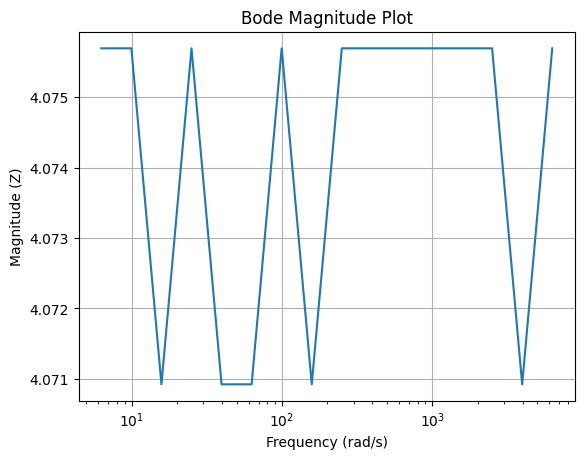

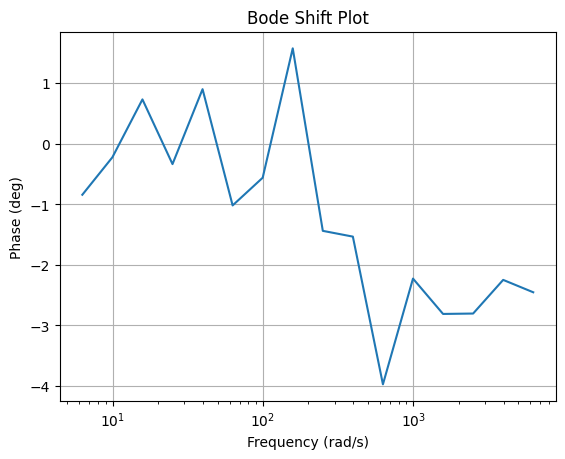

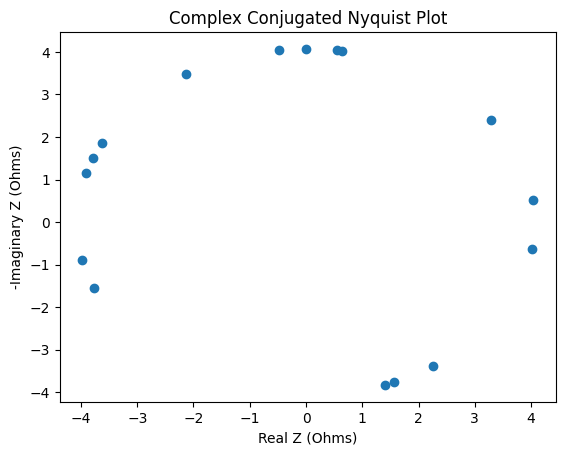

In [45]:
process = EIS("test1")
process.unpack()
frequency = 1.0
sweep_shifts = []
complex_impedances_a = []
complex_impedances_p = []

frequencies_rad = [(2*np.pi*x) for x in list(process.frequency_data.keys())]

for frequency in process.frequency_data:
    print(frequency)
    voltage = process.frequency_data[frequency][1]
    current = process.frequency_data[frequency][2]
    v_zero_crossing = process.zero_crossing_algorithm(voltage)
    v_disp_zeros = []
    for i in range(len(voltage)):
        if i in v_zero_crossing:
            v_disp_zeros.append(2)#(np.max(voltage)+np.min(voltage))/2)
        else:
            v_disp_zeros.append(1)#np.min(voltage))
    # plt.plot(voltage)
    # plt.plot(v_disp_zeros)
    # plt.show()
    i_zero_crossing = process.zero_crossing_algorithm(current)
    i_disp_zeros = []
    for i in range(len(current)):
        if i in i_zero_crossing:
            i_disp_zeros.append(1)#(np.max(current)+np.min(current))/2)
        else:
            i_disp_zeros.append(0)#np.min(current))
    # # plt.plot(v_disp_zeros)
    # # plt.plot(i_disp_zeros)
    # # plt.show()   # # plt.plot(v_disp_zeros)
    # # plt.plot(i_disp_zeros)
    # # plt.show()

    shift = process.get_phase_shift(frequency, v_zero_crossing, i_zero_crossing)
    sweep_shifts.append(shift)
    complex_impedance_amplitude, complex_impedance_phase = process.compute_raw_impedance(frequency, shift)
    complex_impedances_a.append(complex_impedance_amplitude)
    complex_impedances_p.append(complex_impedance_phase)

process.bode_plot_complex_impedance(frequencies_rad, complex_impedances_a, complex_impedances_p)
process.complex_conjugated_nyquist_plot(complex_impedances_a, complex_impedances_p)
#exporter.saveImpedanceData(complex_impedances_a, complex_impedances_p)



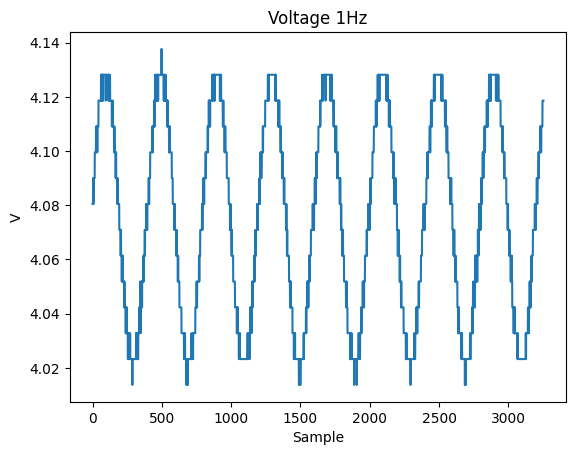

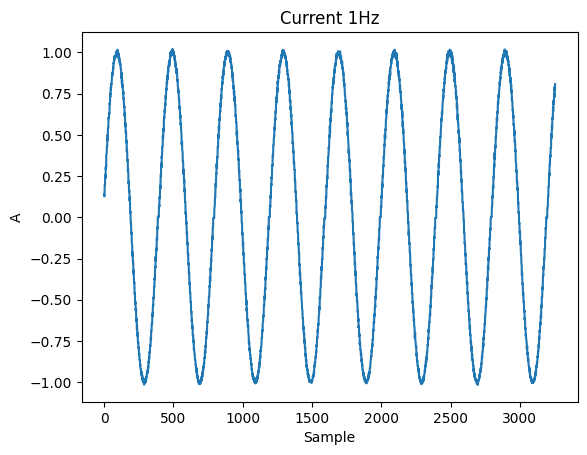

In [ ]:
# plt.plot(process.frequency_data[1.0][1])
# plt.title("Voltage 1Hz")
# plt.xlabel("Sample")
# plt.ylabel("V")
# plt.show()

# plt.plot(process.frequency_data[1.0][2])
# plt.title("Current 1Hz")
# plt.xlabel("Sample")
# plt.ylabel("A")
# plt.show()